In [1]:
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
import math
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('C:/credit_card_default_analysis.csv')

# 1.

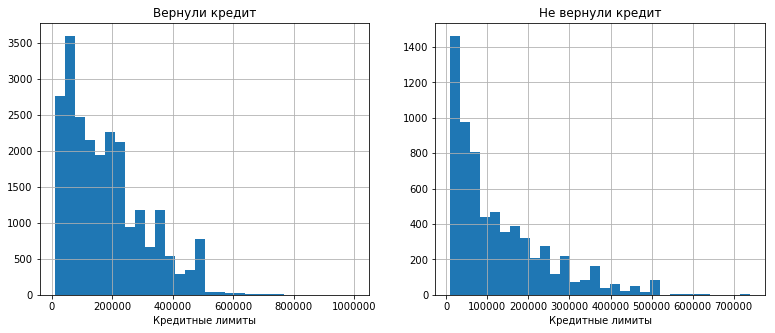

In [3]:
# выделим переменные для рассматриваемых данных

default0 = data[data.default==0].LIMIT_BAL.values
default1 = data[data.default==1].LIMIT_BAL.values

# смотрим на распределения: среднее значение по первой группе, очевидно, больше

_, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].hist(default0, bins=30)
ax[0].grid(), ax[0].set_title('Вернули кредит')
ax[0].set_xlabel('Кредитные лимиты')

ax[1].hist(default1, bins=30)
ax[1].grid(), ax[1].set_title('Не вернули кредит')
ax[1].set_xlabel('Кредитные лимиты')

plt.show()

## 1.a

$H_0: med(X_1) = med(X_2)$

$H_1: med(X_1) \neq med(X_2)$

Проверим с помощью доверительных интервалов на бутстрапированных выборках

In [4]:
# введем вспомогательные функции для оценки интервалов медиан методом бутстрапа 

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data)-1, (n_samples,len(data)))
    return data[indices]

def bootstrap_confint(data, alpha):
    return np.percentile(data, [100*(alpha/2),100*(1-alpha/2)])

In [5]:
# получим по 1000 бутстрапированных выборок для каждой из групп заемщиков

default0_bs = get_bootstrap_samples(default0, 1000)
default1_bs = get_bootstrap_samples(default1, 1000)

In [6]:
# посчитаем медианы по каждой из выборок

default0_med = list(map(np.median, default0_bs))
default1_med = list(map(np.median, default1_bs))

In [7]:
# Ответ 1.a

print('95%-ый доверительный интервал для медиан кредитного лимита:',
      '\n по вернувшим кредит: ', bootstrap_confint(default0_med, 0.05),
      '\n по не вернувшим кредит: ', bootstrap_confint(default1_med, 0.05),
     '\n\nНулевая гипотеза о равенстве медиан отвергается против двусторонней альтернативы на уровне значимости 0.05')

95%-ый доверительный интервал для медиан кредитного лимита: 
 по вернувшим кредит:  [ 150000.  150000.] 
 по не вернувшим кредит:  [ 80000.  90000.] 

Нулевая гипотеза о равенстве медиан отвергается против двусторонней альтернативы на уровне значимости 0.05


## 1.b

$H_0: F_{X_1}(x) = F_{X_2}(x)$

$H_1: F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Проверим с помощью перестановочного критерия

In [8]:
# введем вспомогательные функции для перестановочного критерия

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_combinations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_combinations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [9]:
# Ответ 1.b

print('p-value: ', permutation_test(default0, default1, 1000),
     '\nНулевая гипотеза о равенстве распределений отвергается на уровне значимости 0.05',
     '\nПрактический эффект признается значимым, т.к. медианы двух подвыборок отличаются в ',
      round(np.median(default0)/np.median(default1), 1), ' раз')

p-value:  0.001 
Нулевая гипотеза о равенстве распределений отвергается на уровне значимости 0.05 
Практический эффект признается значимым, т.к. медианы двух подвыборок отличаются в  1.7  раз


# 2.

$H_0: \hat{p_1}\ =  \hat{p_2}\ $

$H_1: \hat{p_1}\ \neq  \hat{p_2}\ $

Проверим с помощью доверительных интервалов и двувыборочного z-критерия для долей независимых выборок

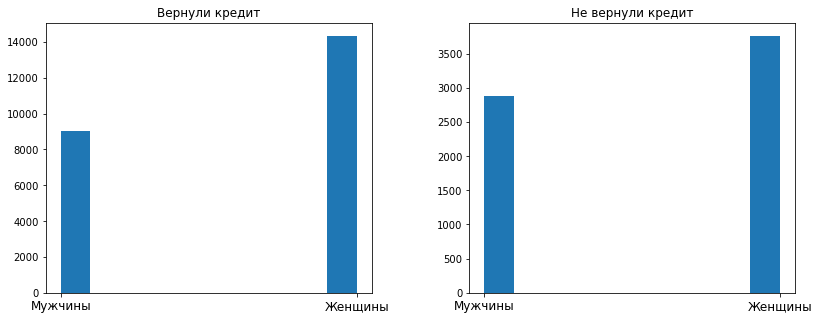

In [10]:
# посмотрим на распределения мужчин(1) и женщин(2) в каждой из подвыборок

data.hist('SEX', 'default', True, figsize=(13,5))

plt.subplot(121).set_title('Вернули кредит')
plt.xticks([1,2], ['Мужчины','Женщины'], rotation=0, size=12)

plt.subplot(122).set_title('Не вернули кредит')
plt.xticks([1,2], ['Мужчины','Женщины'], rotation=0, size=12)

plt.show()

In [11]:
# приведем бинарные случайные величины в соответствие с дальнейшим анализом (0 - женщины, 1 - мужчины)

default0_sex = data[data.default==0].SEX.apply(lambda x: 0 if x==2 else 1).values
default1_sex = data[data.default==1].SEX.apply(lambda x: 0 if x==2 else 1).values

In [12]:
default0_sex.mean(), default1_sex.mean()

# средние отстоят от 0.5, поэтому для подсчета интервалов будем использовать метод Уилсона

(0.38585002568053417, 0.43294153104279687)

In [13]:
print('Доверительный интервал для средней доли мужчин в подвыборке не вернувших кредит -', list(proportion_confint(sum(default1_sex), len(default1_sex), method='wilson')),
     '\n - лежит полностью правее доверительного интервала в подвыборке вернувших кредит -', list(proportion_confint(sum(default0_sex), len(default0_sex), method='wilson')))

Доверительный интервал для средней доли мужчин в подвыборке не вернувших кредит - [0.42106241803493399, 0.44489823697171821] 
 - лежит полностью правее доверительного интервала в подвыборке вернувших кредит - [0.37962731580892511, 0.39211026596987603]


In [14]:
# проверим гипотезу о том, что средние доли мужчин в обеих подвыборках равны

def proportion_2samp_ind(sample1, sample2):
    p1 = sample1.mean()
    p2 = sample2.mean()
    n1 = len(sample1)
    n2 = len(sample2)
    P = (p1*n1 + p2*n2)/(n1 + n2)
    z = (p1 - p2)/math.sqrt(P*(1-P)*(1/n1 + 1/n2))
    pval = 2*(1 - stats.norm.cdf(abs(z)))
    return {'z-stat': z, 'pval': pval}

proportion_2samp_ind(default0_sex, default1_sex)

{'pval': 4.4728665216098307e-12, 'z-stat': -6.9213750885628968}

In [15]:
# Ответ 2.

print('Нулевая гипотеза о равенстве средних долей мужчин среди вернувших и не вернувших кредит отвергается в пользу',
      '\nдвусторонней альтернативы на уровне значимости 0.05 с p-value =', proportion_2samp_ind(default0_sex, default1_sex)['pval'])

Нулевая гипотеза о равенстве средних долей мужчин среди вернувших и не вернувших кредит отвергается в пользу 
двусторонней альтернативы на уровне значимости 0.05 с p-value = 4.47286652161e-12


# 3.

$H_0$: $X_1$ и $X_2$ независимы

$H_1$: $H_0$ не верна

Проверим с помощью критерия хи-квадрат

In [16]:
# по каждой категории образования посчитаем количество заемщиков, вернувших и не вернувших кредит

edu_default0 = pd.get_dummies(data[data.default==0], columns=['EDUCATION'], prefix='EDU').loc[:,['EDU_0','EDU_1','EDU_2','EDU_3','EDU_4','EDU_5','EDU_6']].sum()
edu_default1 = pd.get_dummies(data[data.default==1], columns=['EDUCATION'], prefix='EDU').loc[:,['EDU_0','EDU_1','EDU_2','EDU_3','EDU_4','EDU_5','EDU_6']].sum()
edu_default_observed = pd.DataFrame({'default0': edu_default0, 'default1': edu_default1}, dtype=np.int)

edu_default_observed

,default0,default1
EDU_0,14,0
EDU_1,8549,2036
EDU_2,10700,3330
EDU_3,3680,1237
EDU_4,116,7
EDU_5,262,18
EDU_6,43,8


In [17]:
# Ответ 3.1

print('p-value теста хи-квадрат =', stats.chi2_contingency(edu_default_observed)[1],
     '- гипотеза о независимости уровня образования и возвращаемости кредита отвергается')

p-value теста хи-квадрат = 1.23326262454e-32 - гипотеза о независимости уровня образования и возвращаемости кредита отвергается


In [18]:
# Чтобы показать разницу между наблюдаемыми и ожидаемыми количествами заемщиков в каждой ячейке, выведем значения
# наблюдаемых и ожидаемых долей заемщиков, вернувших долг, по каждому уровню образования

# наблюдаемые доли:
observed_shares = edu_default_observed.apply(lambda x: x[0]/(x[0] + x[1]), 1)

# ожидаемая доля (процент нулей в столбце 'default'):
expected_share = 1 - data.default.mean()

# разница (отсортированная по убыванию):
diff = observed_shares - expected_share
diff.sort_values(ascending=False)

EDU_0    0.221200
EDU_4    0.164289
EDU_5    0.156914
EDU_6    0.064337
EDU_1    0.028852
EDU_2   -0.016149
EDU_3   -0.030376
dtype: float64

In [19]:
# Ответ 3.2

print('Наличие докторской степени (EDU_0) является наилучшим индикатором того, что человек отдаст долг',
     '\nЛучшим индикатором того, что человек не отдаст долг является наличие только школьного образование (EDU_3)')

Наличие докторской степени (EDU_0) является наилучшим индикатором того, что человек отдаст долг 
Лучшим индикатором того, что человек не отдаст долг является наличие только школьного образование (EDU_3)


# 4.

$H_0$: $X_1$ и $X_2$ независимы

$H_1$: $H_0$ не верна

Проверим с помощью коэф. корреляции Мэтьюса и критерия хи-квадрат

In [20]:
print('В столбце MARRIAGE 2 значения признака (0 и 3) отнесем к категории NA и отбросим из рассмотрения,',
      '\nт.к. их доля на всей выборке составляет всего',
      round(len(data[(data.MARRIAGE==0)|(data.MARRIAGE==3)])/len(data), 2))

В столбце MARRIAGE 2 значения признака (0 и 3) отнесем к категории NA и отбросим из рассмотрения, 
т.к. их доля на всей выборке составляет всего 0.01


In [21]:
# удалим объекты с NA

data_new = data.drop(data[(data.MARRIAGE==0)|(data.MARRIAGE==3)].index)

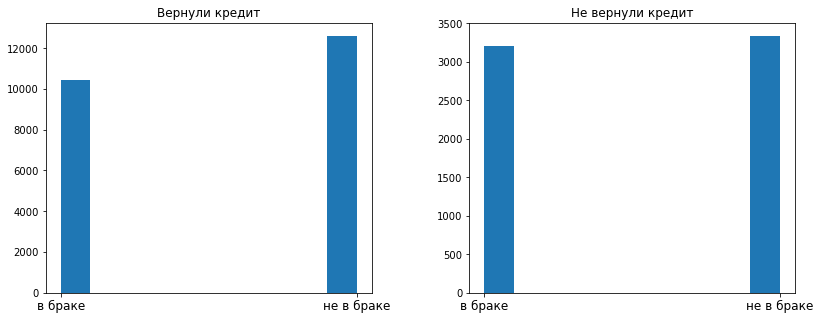

In [22]:
# посмотрим на распределения семейных положений в двух подвыборках

data_new.hist('MARRIAGE', 'default', figsize=(13,5))
plt.subplot(121).set_title('Вернули кредит')
plt.xticks([1,2], ['в браке','не в браке'], rotation=0, size=12)

plt.subplot(122).set_title('Не вернули кредит')
plt.xticks([1,2], ['в браке','не в браке'], rotation=0, size=12)

plt.show()

In [23]:
# переименуем переменные в 'MARRIAGE' для удобства

data['fixMAR'] = data.MARRIAGE.map({1:'замужем/женат', 2:'холост'})

# посчитаем количество заемщиков на пересечении категорий 'MARRIAGE' и 'default'

mar_default0 = pd.get_dummies(data[data.default==0], '', '', columns=['fixMAR']).iloc[:,-2:].sum()[::-1]
mar_default1 = pd.get_dummies(data[data.default==1], '', '', columns=['fixMAR']).iloc[:,-2:].sum()[::-1]

# выведем матрицу сопряженности с правильной расстановкой строк и столбцов

mar_default_observed = pd.DataFrame({'не вернул': mar_default1, 'вернул': mar_default0},
                                    columns=['не вернул', 'вернул'])
mar_default_observed = mar_default_observed.apply(lambda x: x/sum(x))
mar_default_observed

,не вернул,вернул
холост,0.51031,0.547019
замужем/женат,0.48969,0.452981


In [24]:
# посчитаем значение корреляции Мэтьюса

def mathews_cor(matrix):
    a, b, c, d = matrix[0,0], matrix[0,1], matrix[1,0], matrix[1,1]
    return (a*d - b*c)/math.sqrt((a+b)*(a+c)*(b+d)*(c+d))

mathews_cor(mar_default_observed.values)

-0.036768953323777047

In [25]:
# Ответ

print('Согласно коэффициенту Мэтьюса, семейное положение "в браке" демонстрирует незначительную отрицательную корреляцию с возвращаемостью кредита;',
     '\nКритерий хи-квадрат не отвергает независимость данных переменных с p-value =', stats.chi2_contingency(mar_default_observed)[1])

Согласно коэффициенту Мэтьюса, семейное положение "в браке" демонстрирует незначительную отрицательную корреляцию с возвращаемостью кредита; 
Критерий хи-квадрат не отвергает независимость данных переменных с p-value = 0.172396381373


# 5.

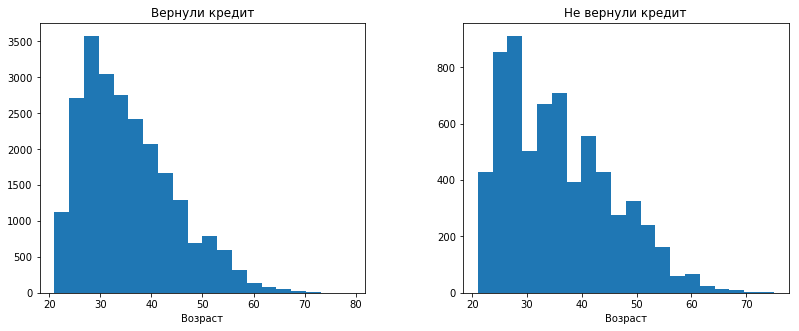

In [26]:
# посмотрим на возрастные распределения в каждой из подвыборок
# единственное значимое отличие - среди не вернувших кредит большая доля вероятностной массы приходится на молодых людей 20-30 лет,
# центральные меры (средняя, медиана, мода) визуально совпадают

data.hist('AGE', 'default', True, figsize=(13,5), bins=20)

plt.subplot(121).set_title('Вернули кредит'), plt.subplot(121).set_xlabel('Возраст')
plt.xticks(rotation=0)

plt.subplot(122).set_title('Не вернули кредит'), plt.subplot(122).set_xlabel('Возраст')
plt.xticks(rotation=0)
plt.show()

## 5.a

$H_0: med(X_1) = med(X_2)$

$H_1: med(X_1) \neq med(X_2)$

Проверим нулевую гипотезу методом доверительных интервалов для бутстрапированных выборок

In [27]:
# выделим переменные для рассматриваемых данных

age0 = data[data.default==0].AGE.values
age1 = data[data.default==1].AGE.values

# получим по 1000 бутстрапированных выборок для каждой из групп заемщиков

age0_bs = get_bootstrap_samples(age0, 1000)
age1_bs = get_bootstrap_samples(age1, 1000)

# посчитаем медианы по каждой из выборок

age0_bs_med = list(map(np.median, age0_bs))
age1_bs_med = list(map(np.median, age1_bs))

In [28]:
# Ответ

print('95%-ые доверительные интервалы для медиан возраста:',
      '\n по вернувшим кредит: ', bootstrap_confint(age0_bs_med, 0.05),
      '\n по не вернувшим кредит: ', bootstrap_confint(age1_bs_med, 0.05),
     '\nследовательно, гипотеза о равенстве медиан не отвергается',
     '\n\nКроме того, разность медиан можно признать практически не значимой')

95%-ые доверительные интервалы для медиан возраста: 
 по вернувшим кредит:  [ 34.  34.] 
 по не вернувшим кредит:  [ 34.  35.] 
следовательно, гипотеза о равенстве медиан не отвергается 

Кроме того, разность медиан можно признать практически не значимой


## 5.b

$H_0: F_{X_1}(x) = F_{X_2}(x)$

$H_1: F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Проверим с помощью перестановочного критерия

In [29]:
#Ответ

print('Гипотеза о равенстве распределений отвергается в пользу двусторонней альтернативы на уровне значимости 0.05',
      'с p-value =', round(permutation_test(age0, age1, 1000), 2))

Гипотеза о равенстве распределений отвергается в пользу двусторонней альтернативы на уровне значимости 0.05 с p-value = 0.02
